# 3rd Group Presentation

## Reminder of The Project

The Idea behind this project is to study techniques from fourier analysis / digital signal processing in conjunction with machine learning methods in order to provide a good classification framework for time series based signals comming from accelerometers with suspected periodic behaviour.

The original context of classification was to detect changes in between two classes or states of the underlying subject from which the time series metrics originated.

## Data sets involved

### http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities

Constitutes of 19 different sport/ daily activities. In which 25hz samples are obtainned from accelerometers, gyroscopes and magnetometers attached to LA, RA, T, LL, RL. 5 seconds per task 8 different people involved in this study a total of 
9120 data points. I have worked on this dataset so far planning on working with the others as soon as I finsih some aspects of my framework which need building/optimizing.

###  http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

This dataset is measured from the accelerometers and gyroscopes in smartphones. Class labels are 3 postures and 3 activities and the number of instances 10929. The advantage of this data set is that it is more timeseries in the sense that the samples contain the transitions from one activity to another which matches more the original data set and proposed problem.

### IceRobotics data set

There was a problem obtaining the dataset with 800 instances due to ownership issues involved in the work carried out on the dataset. This was a major set back. What the company proposed was to give a smaller dataset of ~ 100 samples but due to the small statistical value in this size I decided to work on other similar datasets and then later on if there is time test things out with this one.



## Choice of Technologoes and Frameworks

I played around with scikit learn and lasagne and quickly discovered that they have some limitations and can be quite sensitive when doing changes such as pre initliazing the weight matrix. So I decided to work the the framework we built in Machine learning practical since I worked on it for a very long period of time during the holidays and know it rather well.


In [ ]:
import numpy
import logging
from mlp.dataset import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = ACLDataProvider(dset='train', batch_size=-10, max_num_batches=-10, randomize=True)
valid_dp = ACLDataProvider(dset='valid', batch_size=1824, max_num_batches=1, randomize=False)

## Baseline Experiment

The following experiment uses the right arm y-reading of the accelerometer as its input space on a double hidden layer one linear and one relu activation function based neural network. The choice of hidden units and topology of this baseline experiment was chosen to asses the performance of a fourier transform on the input space vs the original input space.

In [2]:
#Baseline experiment
from copy import deepcopy
from mlp.layers import MLP, Linear, Sigmoid, Softmax, Relu #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

logger = logging.getLogger()
logger.setLevel(logging.INFO)
rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 100
learning_rate = 0.01
max_epochs = 78
cost = CECost()
    
stats = list()

test_dp = deepcopy(valid_dp)
train_dp.reset()
valid_dp.reset()
test_dp.reset()

# NETWORK TOPOLOGY:
model = MLP(cost=cost)
model.add_layer(Linear(idim=125, odim=125*2, irange=1.6, rng=rng))
model.add_layer(Relu(idim=125*2, odim=125*2, irange=1.6, rng=rng))
model.add_layer(Softmax(idim=125*2, odim=19, rng=rng))

# define the optimiser, here stochasitc gradient descent
# with fixed learning rate and max_epochs
lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

logger.info('Training started...')
tr_stats_b, valid_stats_b = optimiser.train(model, train_dp, valid_dp)

logger.info('Testing the model on test set:')

tst_cost, tst_accuracy = optimiser.validate(model,test_dp )
logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))



INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 18.459. Accuracy is 5.56%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 18.304. Accuracy is 5.65%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 14.557. Accuracy is 21.44%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.507. Accuracy is 33.17%
INFO:mlp.optimisers:Epoch 1: Took 0 seconds. Training speed 32732 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.148. Accuracy is 40.32%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.303. Accuracy is 43.86%
INFO:mlp.optimisers:Epoch 2: Took 0 seconds. Training speed 34290 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 1.691. Accuracy is 47.62%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 1.593. Accuracy is 47.70%
INFO:mlp.optimisers:Epoch 3: Took 0 seconds. Training speed 32732 pps. Validation speed 91250 pps.
INFO:mlp.opt

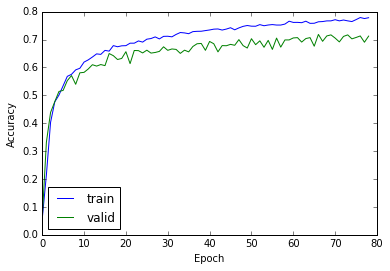

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

a = plt.plot(np.array(tr_stats)[:,1])
b = plt.plot(np.array(valid_stats)[:,1])
plt.legend([a[0], b[0]], ["train", "valid"], loc=3)
plt.xlabel("Epoch");
plt.ylabel("Accuracy");

In [23]:
import random
from itertools import chain

col_func = (lambda x: "#%06x" % random.randint(0, 0xFFFFFF))

def plot_stats(stats, mode='train_acc', shds=None, corr=False, max_epochs=30, figsize=(15,25)):
    title = str(mode)
    mode_dict = {'train_acc': (0,1),
                 'val_acc': (1,1),
                 'test_cost': (2,0),
                 'test_acc': (2,1)}
    if not corr:
        mode = mode_dict[mode]
        plt.figure(figsize=(10,10))
    else:
        fig, ax = plt.subplots(len(stats),figsize=figsize, sharex=True,sharey=True)
        ax = [ax]
        fig.suptitle(title)
    a = list()
    colors = ["#%06x" % random.randint(0, 0xFFFFFF)for i in range(len(stats))]
    
    for j, plo in enumerate(stats):
        
        if not corr:
            a.append(plt.plot(range(len(numpy.array(plo[mode[0]])[:,mode[1]][:max_epochs])),
                      numpy.array(plo[mode[0]])[:,mode[1]][:max_epochs] , '-o', ms=2))
        else:
            mode = mode_dict[corr[0]]
            mode2 = mode_dict[corr[1]]
           
            train_cost = numpy.array(plo[mode[0]])[1:,mode[1]][1:max_epochs]
            test_cost = numpy.array(plo[mode2[0]])[1:,mode2[1]][1:max_epochs]
    
            # euclidean distance of each cost pair from origin: (a metric of their combined error)
            euclid = np.sqrt(test_cost*test_cost + train_cost*train_cost )
            mx_ts = numpy.max(numpy.log(test_cost))
            mn_ts = numpy.min(numpy.log(test_cost))
            # Discretization gets carried out in the next two lines out of our
            # euclid error metric for the bubble plot
            hz, bi = numpy.histogram(euclid, bins=65)
            sz = list(chain(*[[20*c]*hz[c-1]  for c in range(1,len(hz)+1)]))
            
            norm = numpy.sum(euclid)

            label = ax[j].scatter((train_cost),
                                  (test_cost),
                                  s=sz, alpha=0.5, color= colors[j])
            ax[j].set_xlabel("$log($"+title.split("vs")[-1]+"$)$")
            ax[j].set_ylabel("$log($"+title.split("vs")[0]+"$)$")
            

    
    if not corr:
        plt.legend(map(lambda x: x[0],a), shds,loc=5)
        plt.xlabel("epoch number")
        plt.ylabel(title.split("_")[-1])
        
    plt.show()



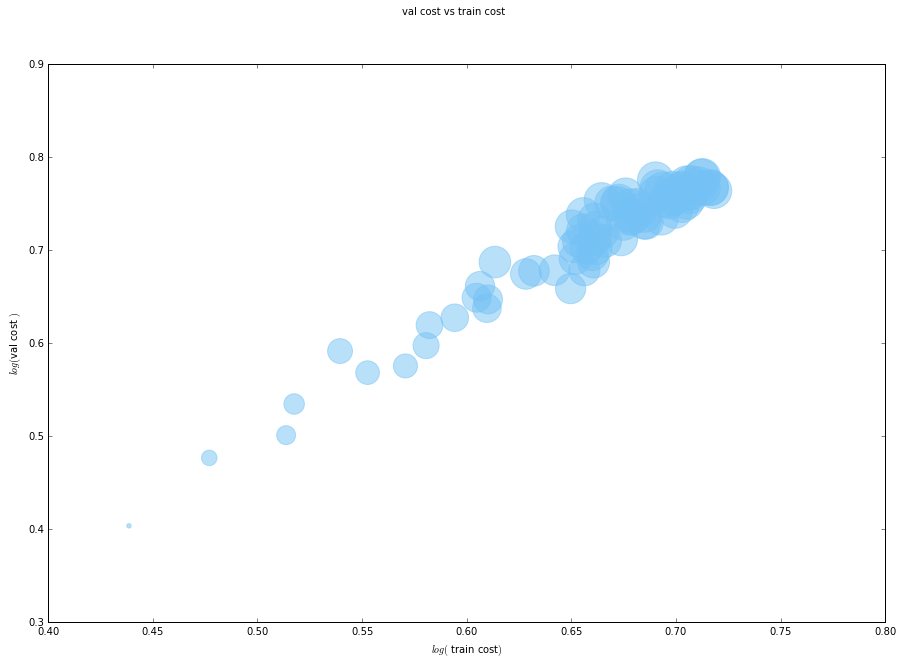

In [26]:
stats1  = [(tr_stats, valid_stats, (tst_cost, tst_accuracy))]
me=78
plot_stats(stats1,'val cost vs train cost',
           shds=["basline"], corr=('val_acc', 'train_acc') ,max_epochs=me, figsize= (15,10))



## Fourier Layer

Instead of transforming the data in to fourier via fft or some other dft scipy function I decided to do this by creating a neural network layer whose weight matrix is initliazed to the DFT matrix  

![](https://raw.githubusercontent.com/franciscovargas/MLPHonoursExtension/master/1.png)

Where :

\begin{equation}
\omega_{j+1k+1}= e^{\frac{-2\pi i*j*k}{2}} \quad j,k \in \{0,1\}
\end{equation}


\begin{equation}
\beta_{1} = \beta_{2} = 0
\end{equation}

\begin{equation}
x_{0} = 1
\end{equation}
In our case example above where the input and the fourier space live in $\mathbb{R}^2$

### Advantages

* Due to the parallel nature of the neural network layer this structure allows for an efficient GPU computation of a fourier transform;
* One can extend the backpropagation algorithm to update the weights in the fourier layer which is a way of relaxing this transformation to the data. 

### Modification to the Network Architecture Due to Complex numbers

Since $f_{i} \in \mathbb{C}$ we need to represent them in a real form such that we can effectively carry out backwards and forward propagation. Taking the square magnitude of it makes the gradients rather ugly thus the easiest way is to map the complex number to a vector in the following form:

\begin{equation}
 x + iy \rightarrow (x,y)
\end{equation}

If we wish to represent this in a network architecture we need to double the number of neurons : 

In [1]:
#matplotlib inline
import numpy
import logging
from mlp.dataset import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = ACLDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = ACLDataProvider(dset='valid', batch_size=1824, max_num_batches=1, randomize=False)


#Baseline experiment
from copy import deepcopy
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.layers import * 
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

logger = logging.getLogger()
logger.setLevel(logging.INFO)
rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 100
learning_rate = 0.01
max_epochs = 78
cost = CECost()
    
stats = list()

test_dp = deepcopy(valid_dp)
train_dp.reset()
valid_dp.reset()
test_dp.reset()

#define the model
model = MLP(cost=cost)
model.add_layer(ComplexLinear(idim=125, odim=125, irange=1.6, rng=rng))
model.add_layer(Relu(idim=2*125, odim=125*2, irange=1.6, rng=rng))
model.add_layer(Softmax(idim=125*2, odim=19, rng=rng))

# define the optimiser, here stochasitc gradient descent
# with fixed learning rate and max_epochs
lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

logger.info('Training started...')
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp, fft=False)

logger.info('Testing the model on test set:')

tst_cost, tst_accuracy = optimiser.validate(model,test_dp )
logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))



INFO:root:Initialising data providers...


(7296, 5625) (7296,)
(7296, 125)
(1824, 5625)

INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 21.188. Accuracy is 6.67%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 21.409. Accuracy is 5.70%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 17.992. Accuracy is 23.44%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.406. Accuracy is 36.57%
INFO:mlp.optimisers:Epoch 1: Took 0 seconds. Training speed 23229 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 1.946. Accuracy is 43.11%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.678. Accuracy is 47.20%
INFO:mlp.optimisers:Epoch 2: Took 0 seconds. Training speed 18950 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 1.600. Accuracy is 51.29%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 1.291. Accuracy is 56.36%
INFO:mlp.optimisers:Epoch 3: Took 0 seconds. Training speed 23229 pps. Validation speed 60833 pps.
INFO:mlp.opt

 (1824,)
(1824, 125)


In [ ]:
import numpy
import logging
from mlp.dataset import *


logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = ACLDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = ACLDataProvider(dset='valid', batch_size=1824, max_num_batches=1, randomize=False)


#Baseline experiment
from copy import deepcopy
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.layers import * 
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

logger = logging.getLogger()
logger.setLevel(logging.INFO)
rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 100
learning_rate = 0.01
max_epochs = 78
cost = CECost()
    
stats = list()

test_dp = deepcopy(valid_dp)
train_dp.reset()
valid_dp.reset()
test_dp.reset()

#define the model
model = MLP(cost=cost)
model.add_layer(DFTLinear(idim=125, odim=125, irange=1.6, rng=rng))
#Every activation function from dft layer produces two values (x,y) for x+iy
model.add_layer(Relu(idim=125*2, odim=125, irange=1.6, rng=rng))
model.add_layer(Softmax(idim=125, odim=19, rng=rng))

# define the optimiser, here stochasitc gradient descent
# with fixed learning rate and max_epochs
lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

logger.info('Training started...')
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

logger.info('Testing the model on test set:')

tst_cost, tst_accuracy = optimiser.validate(model,test_dp )
logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

INFO:root:Initialising data providers...


(7296, 5625) (7296,)
(7296, 125)
(1824, 5625)

INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 18.101. Accuracy is 5.15%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 18.091. Accuracy is 5.70%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 16.511. Accuracy is 19.72%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.370. Accuracy is 31.20%
INFO:mlp.optimisers:Epoch 1: Took 0 seconds. Training speed 60008 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.178. Accuracy is 34.71%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.848. Accuracy is 39.86%
INFO:mlp.optimisers:Epoch 2: Took 0 seconds. Training speed 60008 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 1.846. Accuracy is 40.54%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 1.637. Accuracy is 48.19%
INFO:mlp.optimisers:Epoch 3: Took 0 seconds. Training speed 55392 pps. Validation speed 91250 pps.
INFO:mlp.opt

In [3]:
import numpy
import logging
from mlp.dataset import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = ACLDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = ACLDataProvider(dset='valid', batch_size=1824, max_num_batches=1, randomize=False)


#Baseline experiment
from copy import deepcopy
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.layers import * 
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

logger = logging.getLogger()
logger.setLevel(logging.INFO)
rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 100
learning_rate = 0.01
max_epochs = 78
cost = CECost()
    
stats = list()

test_dp = deepcopy(valid_dp)
train_dp.reset()
valid_dp.reset()
test_dp.reset()


#define the model
model = MLP(cost=cost)
model.add_layer(DFTAugLinear(idim=125, odim=125, irange=1.6, rng=rng))
model.add_layer(Relu(idim=125*3, odim=125, irange=1.6, rng=rng))
model.add_layer(Softmax(idim=125, odim=19, rng=rng))

# define the optimiser, here stochasitc gradient descent
# with fixed learning rate and max_epochs
lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

logger.info('Training started...')
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

logger.info('Testing the model on test set:')

tst_cost, tst_accuracy = optimiser.validate(model,test_dp )
logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

INFO:root:Initialising data providers...


(7296, 5625) (7296,)
(7296, 125)
(1824, 5625)

INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 14.652. Accuracy is 5.53%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 14.479. Accuracy is 6.36%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 17.028. Accuracy is 18.62%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.552. Accuracy is 29.88%
INFO:mlp.optimisers:Epoch 1: Took 0 seconds. Training speed 45006 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.148. Accuracy is 34.43%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.830. Accuracy is 37.72%
INFO:mlp.optimisers:Epoch 2: Took 0 seconds. Training speed 45006 pps. Validation speed 91250 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 1.862. Accuracy is 38.42%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 1.690. Accuracy is 45.23%
INFO:mlp.optimisers:Epoch 3: Took 0 seconds. Training speed 37900 pps. Validation speed 60833 pps.
INFO:mlp.opt

 (1824,)
(1824, 125)
